# 神经网络初步

在监督学习中，我们的目标是使用特征$x$的函数，$f(x)$，对某个输出$y$进行拟合。我们之前所学的线性回归、非线性回归、Logistic回归等方法都可以看作是设定了一个$f(x)$的函数形式：$f(x,\theta)$，通过最小化损失的方式找到一个$\theta^*$使得$f(x,\theta^*)$的预测最准确。而分类树、支持向量机等方法则是寻求非参数的方法确定$f(x)$。

而**神经网络**（**neural networks**）则是使用了第一种方法的思想，不过为了减轻函数形式的假设，通过模拟生物的神经系统的方法，组合大量的“**神经元**（**neuron**）”，找到了一族非常特殊而又具有极强表达模型能力的函数形式。从这点而言，简单的神经网络模型其实与我们所学的回归模型等方法并没有本质上的不同，只不过神经网络使用了神经元的网络结构构造了更加灵活的函数形式而已。

最常用、最简单的神经网络是所谓**深度前馈网络**（**deep feed-forward networks**）或者**多层感知机**（**multilayer perceptrons, MLP**）。所谓“前馈”，即从输入（input），通过一定的计算得到隐含变量，最后再进行计算得到输出（output）的过程，而没有反馈（feedback）。

其中，隐含变量是通过输入计算得到的，我们通常称其为**隐含层**（**hidden layer**），比如一个简单的单层网络：
![](pic/nn_1_hidden.gv.png "单层前馈网络")
其中第一层为输入层（input layer），中间一层使用输入层得到了隐含层（hidden layer），最后一层使用隐藏层计算了输出层（output layer）。此外注意输出层可以不止有一个输出，可以由更多的输出，就像我们在计量经济学中的系统估计、多元Probit、多元Logistic等一样，将紧密相关的几个不同输出放在一个模型中进行训练会给模型带来更多的信息。

当然，也可以继续加入隐含层，比如以下是一个二层网络：
![](pic/nn_2_hidden.gv.png "双层前馈网络")
在以上单层网络的基础上，我们又加入了一个隐含层，就变成了双层前馈网络。以上过程还可以继续，隐含层的层数我们将其称之为这个网络的**深度**（**depth**），所以“深度学习”的简单理解就是深度比较高的神经网络。

其中，隐含层的每一个节点都是一个神经元。所谓神经元，就是使用输入通过一定的函数计算得到一个输出。观察以上的两个网络，每一个隐含层都会使用上一层的所有输出作为这一层的输入，而且不存在跨层，我们称这类网络为**全连接网络**（**fully-connected**）。每一层的神经元的个数成为“**宽度**”（**width**）。

如果我们记$f_{li}\left(h_{l-1}\right)$记为该函数，其中$h_{l-1}$为第$l-1$层的输出，而$f_{li}$则为第$l$层的第$i$个神经元，$h_{0}$即为输入$x$，同时记$$f_l\left(h_{l-1}\right)=\left[f_{l1},f_{l2},...,f_{l,K_l}\right]'$$其中$K_l$为第$l$层的神经元个数，那么神经网络可以使用一个嵌套函数：$$y=f_L\left(f_{L-1}\left(f_{L-2}\left(\cdots f_1\left(x\right)\right)\right)\right)$$值得注意的是，从以上公式中我们可以看出，所有的函数并不能是线性函数：如果所有的$f$都是线性函数，那么最终整个模型也不过就是一个线性函数而已。所以一般而言，每个神经元的计算函数$f_{li}$不能取线性函数。我们将在下面详细介绍神经元的构建。

所有的神经元构成了一个有向无环图，给定一个**损失函数**（**loss function**），比如$$\sum_{i=1}^N ||y_i-\hat{y_i}||_2$$其中$\hat{y_i}$为神经网络的预测，那么最小化以上损失函数就可以得到$f_{li}$的估计，从而最终得到预测函数。而正如前面所学的，为了最小化以上的损失函数，通常使用梯度下降法，而计算导数的过程是逆向求导的：求导的方向是从输出层到输入层，所以求解该最优化问题的方法也叫做“**反向传播**”（**back-propagation**，简称**BP**）算法。

而这个过程完全可以使用PyTorch进行：我们只需要将计算图表达出来，利用PyTorch的自动求导功能，并使用PyTorch中的各种优化方法，就可以找到$\hat{y_i}$的最优参数。

根据**万能近似定理**（**universal approximation theorem**），具有足够多隐藏神经元的网络（具有足够深度、宽度）可以逼近任何的Borel可测特别是连续函数。当然，逼近的效果取决于网络的结构，包括宽度、深度以及神经元的设计。接下来我们将主要介绍神经网络的结构设计。在此之前，我们不妨先通过一个简单的例子理解神经网络的工作原理。

# 一个简单的例子：学习异或函数

**异或函数**（**XOR**）是一个常用的逻辑函数，其定义为：$$0\ \ XOR\ \ 0=0 \\ 1\ \ XOR\ \ 0=1 \\ 0\ \ XOR\ 1\ =1 \\ 1\ \ XOR\ \ 1=0$$即如果两个输入全是0或者全是1，则输出为0；只有当两个输入中一个为1一个为0时，输出为1。

比如，我们可以先生成一组随机的数据：

In [1]:
import numpy as np

N=1000
X=np.random.random((N,2))>0.5
X=X.astype('int32')
X

array([[1, 1],
       [1, 1],
       [1, 1],
       ...,
       [0, 1],
       [1, 1],
       [0, 0]], dtype=int32)

注意为了放到PyTorch中我们将数值类型转化为Float32，然后生成标签：

In [2]:
Y=((X.sum(axis=1))==1).astype('float32')
X=X.astype('float32')
Y[0:10]

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32)

我们使用了函数$y=1\left\{x_1+x_2==1\right\}$生成$y$，然而注意到以上函数并不是一个线性函数。

我们不妨使用一个简单的只有一层隐含层，两个隐含神经元的网络：
![](pic/nn_xor_hidden.gv.png "学习异或")

可以想象，如果我们令：$$h_1=b_{10}+b_{11}x_1+b_{12}x_2 \\ h_1=b_{20}+b_{21}x_1+b_{22}x_2 \\ y=b_0+b_1 h_1+b_2 h_2$$那么$$y=b_0+b_1\left(b_{10}+b_{11}x_1+b_{12}x_2\right)+b_2\left(b_{20}+b_{21}x_1+b_{22}x_2\right)$$仍然是一个线性函数，不可能学习到异或函数。

为此，我们转而将以上函数取为非线性函数，比如，一个简单的方法是使用**激活函数**（**activation function**），即把来自于上一层的输出的线性组合，通过一个一元非线性函数变换得到该神经元的输出。比如，一个常用的激活函数是**线性整流函数**（**Rectified Linear Unit**, **ReLU**）：$$g\left(x\right)=\begin{cases}
0 & x<0\\
x & x\geq0
\end{cases}$$
函数图像为：
![](pic/ReLU.png "ReLU函数")

使用该函数，我们可以将其写为：$$h_1=g\left(b_{10}+b_{11}x_1+b_{12}x_2\right) \\ h_1=g\left(b_{20}+b_{21}x_1+b_{22}x_2\right) \\ y=b_0+b_1 h_1+b_2 h_2$$
观察数据生成过程$y=1\left\{x_1+x_2==1\right\}$可以看到，$y$的生成依赖于两个$x$相加，我们不妨猜测$b_{11}=b_{12}=b_{21}=b_{22}=1$，从而得到：$$h_1=g\left(b_{10}+x_1+x_2\right) \\ h_1=g\left(b_{20}+x_1+x_2\right) \\ y=b_0+b_1 h_1+b_2 h_2$$对于输入：$$\left[\begin{array}{cc}
0 & 0\\
0 & 1\\
1 & 0\\
1 & 1
\end{array}\right]$$正确的输出结果为：$$\left[\begin{array}{c}
0\\
1\\
1\\
0
\end{array}\right]$$第一步经过相加后，输入就变成了：$$\left[\begin{array}{c}
0\\
1\\
1\\
2
\end{array}\right]$$我们可以先结合ReLU函数的特点，把两个特殊的值：$0,2$取出来，比如，可以令$b_{10}=-0.5,b_{20}=-1$，经过计算后得到：结果分别为：$$\left[\begin{array}{c}
-0.5\\
0.5\\
0.5\\
1.5
\end{array}\right]\left[\begin{array}{c}
-1\\
0\\
0\\
1
\end{array}\right]$$经过ReLU函数的激活就变成了：$$\left[\begin{array}{c}
0\\
0.5\\
0.5\\
1.5
\end{array}\right]\left[\begin{array}{c}
0\\
0\\
0\\
1
\end{array}\right]$$注意到：$$2\left[\begin{array}{c}
0\\
0.5\\
0.5\\
1.5
\end{array}\right]-3\left[\begin{array}{c}
0\\
0\\
0\\
1
\end{array}\right]=\left[\begin{array}{c}
0\\
1\\
1\\
0
\end{array}\right]$$从而，令$b_0=0,b_2=2,b_3=-3$就可以得使得以上网络能够学习到异或函数了。当然，从统计学角度，以上的所有参数都是不可识别的：有不止一组解能够达到与以上参数相同的结果。所以实际数据计算的结果可能会与以上结果有偏差，但是预测结果应该是一样的。

结合以上例子，对于神经网络的一个最简单的理解就是：每一个神经元就像一个小“开关”一样，当该神经元的输入（线性组合）达到了一定的阈值，那么就处于开启的状态（激活了），否则就处于关闭的状态。我们可以通过很多很多这样的小开关来判断当期的状态，进而判断此时的$y$的值。

我们可以使用PyTorch对以上数据进行训练，首先准备数据：

In [3]:
import torch
from torch.utils.data import Dataset,DataLoader

class xor_data(Dataset):
    def __len__(self):
        return X.shape[0]
    def __getitem__(self, i):
        x=X[i,:]
        y=Y[i]
        data=torch.from_numpy(x)
        label=torch.tensor(y)
        return data, label
data=xor_data()
# xor_dl=DataLoader(data, batch_size=4, shuffle=True, pin_memory=True)
xor_dl=DataLoader(data, batch_size=data.__len__(), pin_memory=True)

In [4]:
import torch.optim as optim
# 设置初始值
b1=torch.rand(3, requires_grad=True)
b2=torch.rand(3, requires_grad=True)
b=torch.rand(3, requires_grad=True)
optimizer=optim.Adagrad([b1,b2,b], lr=0.01)
Zero=torch.tensor(0.0)
for i in range(100):
    for x,y in xor_dl:
        xb1=torch.mv(x,b1[:-1])+b1[-1]
        xb1=torch.max(Zero,xb1)
        xb2=torch.mv(x,b2[:-1])+b2[-1]
        xb2=torch.max(Zero,xb2)
        xb=b[0]*xb1+b[1]*xb2+b[2]
        loss=torch.sum((y-xb)**2)
        # 梯度清零
        optimizer.zero_grad()
        # 计算梯度
        loss.backward()
        # 迭代
        optimizer.step()
print(b1)
print(b2)
print(b)

tensor([-0.0877,  0.4517,  0.7853], requires_grad=True)
tensor([0.6388, 0.2758, 0.4455], requires_grad=True)
tensor([0.7889, 0.7017, 0.2871], requires_grad=True)


以上我们使用了前面所学的PyTorch的计算图对以上模型进行了计算。然而在大型的神经网络中，如果使用以上方法一个个定义参数，将会非常麻烦。PyTorch中，可以使用神经网络工具箱torch.nn使用简单的编程语言来对以上模型进行建模，就像搭积木一样把整个模型搭建起来。首先导入神经网络工具箱：

In [5]:
from torch import nn
# device=torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
device=torch.device("cpu")

接下来，为了构建神经网络模型，需要创建一个神经网络模型的类：

In [6]:
class XOR_net(nn.Module):
    def __init__(self):
        super(XOR_net, self).__init__()
        # 第一层：线性组合，2个输入2个输出
        self.layer1=nn.Sequential(nn.Linear(2,2),nn.ReLU(inplace=True))
        # 第二层：线性组合，2个输入1个输出
        self.layer2=nn.Sequential(nn.Linear(2,1))
    def forward(self,x):
        x=self.layer1(x)
        x=self.layer2(x)
        return x

model=XOR_net().to(device)

我们解释一下上面的类。首先，该类继承自nn.Module，nn.Module是一个抽象类，我们需要将该类的函数进行重载从而定义模型。

接下来，使用：
```python
super(XOR_net, self).__init__()
```
进行了初始化。

nn.Sequential()可以看做是创建了一个计算的“容器”，即按照顺序对输入进行处理，并得到输出。其中，nn.Linear(m,n)即构建一个线性组合，有m个输入以及n个输出。而nn.ReLU即对上一层的计算结果进行ReLU的变换。

使用如上的方法，我们构造了两个层，第一层有2个输入2个输出，第二层有2个输入1个输出。

如果需要给每个层命名，在构造Sequantial时也可以使用有序词典：
```python
self.layer1=nn.Sequential(OrderedDict([
            ('Layer1_linear_combine', nn.Linear(2,2)),
            ('Layer1_ReLU', nn.ReLU(inplace=True))
        ]))
```


接下来，定义forward()方法，将输入x通过不同层的计算得到输出的前向传播过程。

如此我们就定义了一个简单的网络。

接下来，可以继续定义损失函数，并进行迭代：

Parameter containing:
tensor([[ 1.0817, -1.0843],
        [-0.5130,  0.0800]], requires_grad=True)
Parameter containing:
tensor([-0.0069, -0.0820], requires_grad=True)
Parameter containing:
tensor([[ 0.6360, -0.1031]], requires_grad=True)
Parameter containing:
tensor([0.3165], requires_grad=True)


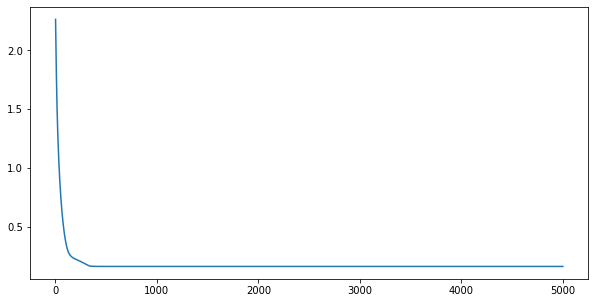

In [7]:
criterion=nn.MSELoss()
optimizer=optim.Adam(model.parameters(), lr=0.01)
losses=[]
for i in range(5000):
    for x,y in xor_dl:
        # 将x计算预测值
        y_pred=model(x.to(device))
        # 计算损失
        loss=criterion(y_pred, y.to(device).unsqueeze(1))
        losses.append(loss.item())
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
for p in model.parameters():
    print(p)
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 5.0)

i=np.arange(len(losses))+1
plt.plot(i,np.array(losses))
plt.show()

接下来，可以使用该模型进行预测，比如

In [8]:
X_pred=torch.tensor([[0.0,0],[0,1],[1,0],[1,1]]).to(device)

# 改为预测模式
model.eval()
# 预测
result=model(X_pred)
print(result)

tensor([[0.3165],
        [0.3165],
        [1.0000],
        [0.3165]], grad_fn=<AddmmBackward>)


Parameter containing:
tensor([[ 0.3299,  0.8101],
        [-0.9709,  1.0429]], requires_grad=True)
Parameter containing:
tensor([-0.4223, -0.0414], requires_grad=True)
Parameter containing:
tensor([[-0.7182,  0.7755]], requires_grad=True)
Parameter containing:
tensor([0.4961], requires_grad=True)


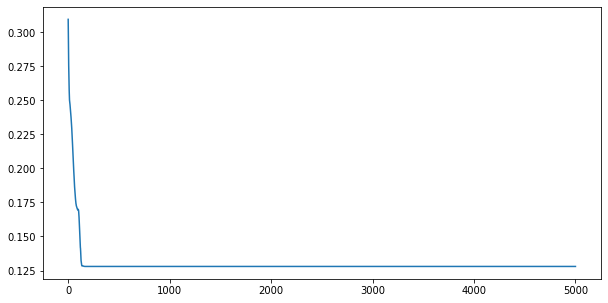

In [9]:
class XOR_net(nn.Module):
    def __init__(self):
        super(XOR_net, self).__init__()
        # 第一层：线性组合，2个输入2个输出
        self.layer1=nn.Sequential(nn.Linear(2,2),nn.LeakyReLU(inplace=True))
        # 第二层：线性组合，2个输入1个输出
        self.layer2=nn.Sequential(nn.Linear(2,1))
    def forward(self,x):
        x=self.layer1(x)
        x=self.layer2(x)
        return x

model=XOR_net().to(device)
criterion=nn.MSELoss()
optimizer=optim.Adam(model.parameters(), lr=0.01)
losses=[]
for i in range(5000):
    for x,y in xor_dl:
        # 将x计算预测值
        y_pred=model(x.to(device))
        # 计算损失
        loss=criterion(y_pred, y.to(device).unsqueeze(1))
        losses.append(loss.item())
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
for p in model.parameters():
    print(p)
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 5.0)

i=np.arange(len(losses))+1
plt.plot(i,np.array(losses))
plt.show()

In [10]:
X_pred=torch.tensor([[0.0,0],[0,1],[1,0],[1,1]]).to(device)

# 改为预测模式
model.eval()
# 预测
result=model(X_pred)
print(result)

tensor([[0.4988],
        [0.9944],
        [0.4889],
        [0.0045]], grad_fn=<AddmmBackward>)


Parameter containing:
tensor([[-1.0816,  0.5649],
        [-0.6942, -0.7065],
        [ 1.4676,  0.0814],
        [ 1.0830, -0.1864],
        [ 0.9280, -0.9587],
        [-1.0384,  0.5662]], requires_grad=True)
Parameter containing:
tensor([ 0.5251,  0.6957, -1.5220, -1.2890,  0.0199,  0.4783],
       requires_grad=True)
Parameter containing:
tensor([[ 0.4168, -0.7530, -1.4794, -0.5477,  1.0320,  0.4786]],
       requires_grad=True)
Parameter containing:
tensor([0.0260], requires_grad=True)


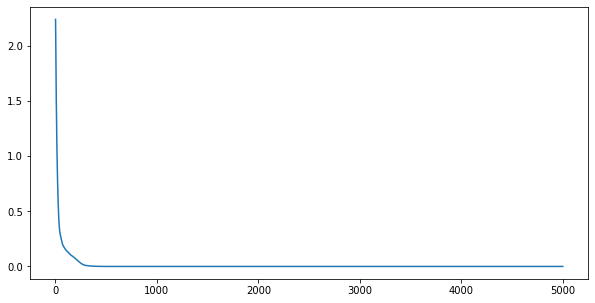

In [11]:
class XOR_net(nn.Module):
    def __init__(self):
        super(XOR_net, self).__init__()
        # 第一层：线性组合，2个输入2个输出
        self.layer1=nn.Sequential(nn.Linear(2,6),nn.LeakyReLU(inplace=True))
        # 第二层：线性组合，2个输入1个输出
        self.layer2=nn.Sequential(nn.Linear(6,1))
    def forward(self,x):
        x=self.layer1(x)
        x=self.layer2(x)
        return x

model=XOR_net().to(device)
criterion=nn.MSELoss()
optimizer=optim.Adam(model.parameters(), lr=0.01)
losses=[]
for i in range(5000):
    for x,y in xor_dl:
        # 将x计算预测值
        y_pred=model(x.to(device))
        # 计算损失
        loss=criterion(y_pred, y.to(device).unsqueeze(1))
        losses.append(loss.item())
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
for p in model.parameters():
    print(p)
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 5.0)

i=np.arange(len(losses))+1
plt.plot(i,np.array(losses))
plt.show()

In [12]:
X_pred=torch.tensor([[0.0,0],[0,1],[1,0],[1,1]]).to(device)

# 改为预测模式
model.eval()
# 预测
result=model(X_pred)
print(result)

tensor([[4.2282e-07],
        [1.0000e+00],
        [1.0000e+00],
        [9.2182e-06]], grad_fn=<AddmmBackward>)
